# Analysis of the improvement in refitting with ESS regularization compared to w/o ESS regularization (on 50% training set fraction)
A variety of $r$s were used; $r=512$ was plotted without a priori knowledge of which $r$ value is optimal at 50% training data split.

In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import pickle
import os
import numpy as np
from jax import numpy as jnp
import matplotlib
from matplotlib import pyplot as plt

from timemachine.fe.refitting import load_pkl_data, compute_95_ci_ecdf
from timemachine.fe.refitting import EMBED_DIM, BETA
from timemachine.constants import KCAL_TO_KJ
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
matplotlib.rcParams['pdf.fonttype'] = 42  # save text as font, not path
KT_TO_KCAL = 1. / BETA / KCAL_TO_KJ

The OpenEye Toolkits are found to be installed but not licensed and therefore will not be used.
The OpenEye Toolkits require a (free for academics) license, see https://docs.eyesopen.com/toolkits/python/quickstart-python/license.html
The OpenEye Toolkits are found to be installed but not licensed and therefore will not be used.
The OpenEye Toolkits require a (free for academics) license, see https://docs.eyesopen.com/toolkits/python/quickstart-python/license.html


In [2]:
def rmse(arr1, arr2):
    return jnp.sqrt(jnp.mean((arr1 - arr2)**2))

def singular_bootstrap_improvement(key, exp_dgs, orig_calc_dgs, reweight_calc_dgs):
    num_dgs = len(exp_dgs)
    key1, key2 = jax.random.split(key, num=2)
    bs_idxs1 = jax.random.choice(key1, jnp.arange(num_dgs), shape=(num_dgs,), replace=True)
    bs_idxs2 = jax.random.choice(key2, jnp.arange(num_dgs), shape=(num_dgs,), replace=True)

    orig_rmses = rmse(exp_dgs[bs_idxs1], orig_calc_dgs[bs_idxs1])
    new_rmses = rmse(exp_dgs[bs_idxs2], reweight_calc_dgs[bs_idxs2])
    return orig_rmses - new_rmses 

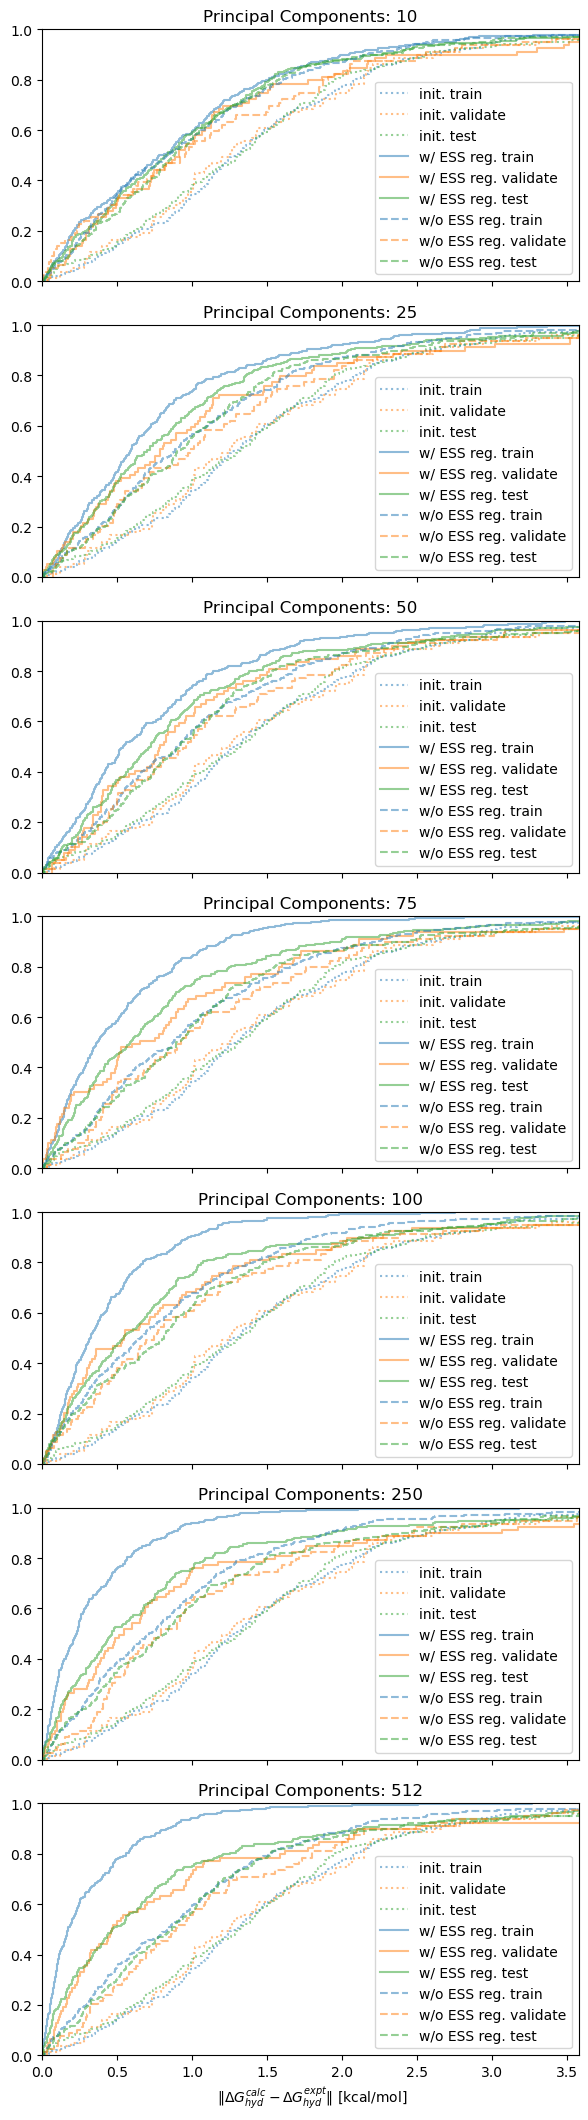

In [3]:
USE_ML = False
RETRIEVE_BY_DESCENT = False
CUTOFF_NESS_THRESHOLD = 0.1
train_fraction = 0.5

drmse_dict = {}
param_dict = {}
key = jax.random.PRNGKey(32)

fig, axes = plt.subplots(7,1, figsize=(6, 21), sharex=True, sharey=True)
for row_idx, num_pcs in enumerate([10, 25, 50, 75, 100, 250, EMBED_DIM]):
    for col_idx, use_ESS in enumerate([True, False]): # t2 uses ESS reg, t3 does not
        key, split_key = jax.random.split(key)
        data = load_pkl_data(f"{num_pcs}_{RETRIEVE_BY_DESCENT}_{train_fraction}_{USE_ML}_{use_ESS}.t5.freesolv.pkl")
        [(res, callback_nums), params, train_loss_auxs, test_loss_auxs, validate_loss_auxs, train_idxs, test_idxs, validate_idxs, cache] = data
        param_dict[(use_ESS, num_pcs)] = params
        
        # train
        (tr_ESS, tr_delta_us, tr_orig_calc_dg, 
         tr_reweighted_solv_dg, tr_reweighted_solv_ddg, 
         tr_exp_dg, tr_ligand_tm_charges, tr_orig_es_ss, tr_mod_es_ss) = train_loss_auxs
        
        # test
        (te_ESS, te_delta_us, te_orig_calc_dg, 
         te_reweighted_solv_dg, te_reweighted_solv_ddg, 
         te_exp_dg, te_ligand_tm_charges, te_orig_es_ss, te_mod_es_ss) = test_loss_auxs

        # validate
        (vl_ESS, vl_delta_us, vl_orig_calc_dg, 
         vl_reweighted_solv_dg, vl_reweighted_solv_ddg, 
         vl_exp_dg, vl_ligand_tm_charges, vl_orig_es_ss, vl_mod_es_ss) = validate_loss_auxs
        
        train_abs_resids = np.abs(tr_orig_calc_dg - tr_exp_dg)
        test_abs_resids = np.abs(te_orig_calc_dg - te_exp_dg)
        validate_abs_resids = np.abs(vl_orig_calc_dg - vl_exp_dg)

        # plot the ECDF of the final resid dgs ()
        train_final_rmse = np.sqrt(np.mean(np.array([(i-j)**2 for i, j, k in zip(tr_reweighted_solv_dg, tr_exp_dg, tr_ESS) if k > CUTOFF_NESS_THRESHOLD])))
        #train_final_rmse = rmse(tr_reweighted_solv_dg, tr_exp_dg)
        validate_final_rmse = np.sqrt(np.mean(np.array([(i-j)**2 for i, j, k in zip(vl_reweighted_solv_dg, vl_exp_dg, vl_ESS) if k > CUTOFF_NESS_THRESHOLD])))
        test_final_rmse = np.sqrt(np.mean(np.array([(i-j)**2 for i, j, k in zip(te_reweighted_solv_dg, te_exp_dg, te_ESS) if k > CUTOFF_NESS_THRESHOLD])))
        #test_final_rmse = rmse(te_reweighted_solv_dg, te_exp_dg)

        train_final_idxs = jnp.argwhere(tr_ESS >= CUTOFF_NESS_THRESHOLD).flatten()
        validate_final_idxs = jnp.argwhere(vl_ESS >= CUTOFF_NESS_THRESHOLD).flatten()
        test_final_idxs = jnp.argwhere(te_ESS >= CUTOFF_NESS_THRESHOLD).flatten()
        
        train_final_resids = np.abs(tr_reweighted_solv_dg[train_final_idxs] - tr_exp_dg[train_final_idxs])
        validate_final_resids = np.abs(vl_reweighted_solv_dg[validate_final_idxs] - vl_exp_dg[validate_final_idxs])
        test_final_resids = np.abs(te_reweighted_solv_dg[test_final_idxs] - te_exp_dg[test_final_idxs])

        # now bootstrap_rmses
        #print(tr_exp_dg[train_final_idxs])
        tr_key, vl_key, te_key = jax.random.split(split_key, num=3)
        tr_rmse_bs = jax.vmap(singular_bootstrap_improvement, in_axes=(0,None,None,None))(
            jax.random.split(tr_key, num=1000), 
            tr_exp_dg[train_final_idxs], 
            tr_orig_calc_dg[train_final_idxs], 
            tr_reweighted_solv_dg[train_final_idxs])
        vl_rmse_bs = jax.vmap(singular_bootstrap_improvement, in_axes=(0,None,None,None))(
            jax.random.split(vl_key, num=1000), 
            vl_exp_dg[validate_final_idxs], 
            vl_orig_calc_dg[validate_final_idxs], 
            vl_reweighted_solv_dg[validate_final_idxs])
        te_rmse_bs = jax.vmap(singular_bootstrap_improvement, in_axes=(0,None,None,None))(
            jax.random.split(te_key, num=1000), 
            te_exp_dg[test_final_idxs], 
            te_orig_calc_dg[test_final_idxs], 
            te_reweighted_solv_dg[test_final_idxs])

        # append
        drmse_dict[(num_pcs, use_ESS)] = [tr_rmse_bs, vl_rmse_bs, te_rmse_bs]

        if use_ESS: # only plot once (is same w/o)
            axes[row_idx].ecdf(np.array(train_abs_resids) * KT_TO_KCAL, color=default_colors[0], 
                                        label=f"init. train", ls=':', alpha=0.5)
            axes[row_idx].ecdf(np.array(validate_abs_resids) * KT_TO_KCAL, color=default_colors[1], 
                                        label=f"init. validate", ls=':', alpha=0.5)
            axes[row_idx].ecdf(np.array(test_abs_resids) * KT_TO_KCAL, color=default_colors[2], 
                                        label=f"init. test", ls = ':', alpha=0.5)

        ls = '--' if not use_ESS else '-'
        mod_label = f"w/ ESS reg." if use_ESS else f"w/o ESS reg."
        axes[row_idx].ecdf(train_final_resids * KT_TO_KCAL, color=default_colors[0], 
                                    label = f"{mod_label} train", ls=ls, alpha=0.5)
        axes[row_idx].ecdf(validate_final_resids * KT_TO_KCAL, color=default_colors[1], 
                                    label = f"{mod_label} validate", ls=ls, alpha=0.5)
        axes[row_idx].ecdf(test_final_resids * KT_TO_KCAL, color=default_colors[2], 
                                    label = f"{mod_label} test", ls=ls, alpha = 0.5)

        axes[row_idx].set_title(f"Principal Components: {num_pcs}")
        axes[row_idx].set_xlim(0, 6 * KT_TO_KCAL)
        axes[row_idx].legend()
        
plt.tight_layout()
axes[row_idx].set_xlabel(r" $\| \Delta G_{hyd}^{calc}  - \Delta G_{hyd}^{expt} \| $ [kcal/mol]")
plt.savefig("fig3_woESS_comparison_supp.pdf", format="pdf", dpi=300)

/scratch/choderaj/rufad/ipykernel_913411/1309832339.py:95: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes.legend()


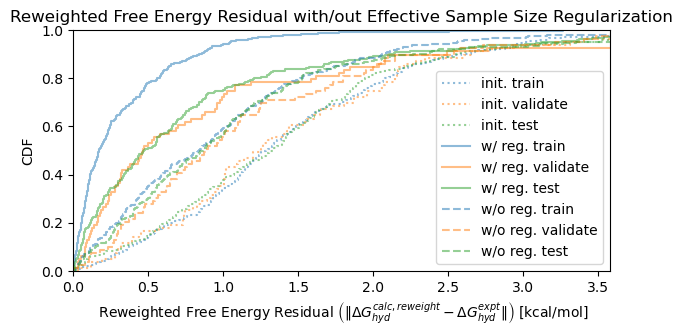

In [4]:
USE_ML = False
RETRIEVE_BY_DESCENT = False
CUTOFF_NESS_THRESHOLD = 0.1
train_fraction = 0.5

drmse_dict = {}
param_dict = {}
key = jax.random.PRNGKey(32)

fig, axes = plt.subplots(figsize=(6, 3))
for row_idx, num_pcs in enumerate([10, 25, 50, 75, 100, 250, EMBED_DIM]):
    for col_idx, use_ESS in enumerate([True, False]): # t2 uses ESS reg, t3 does not
        key, split_key = jax.random.split(key)
        data = load_pkl_data(f"{num_pcs}_{RETRIEVE_BY_DESCENT}_{train_fraction}_{USE_ML}_{use_ESS}.t5.freesolv.pkl")
        [(res, callback_nums), params, train_loss_auxs, test_loss_auxs, validate_loss_auxs, train_idxs, test_idxs, validate_idxs, cache] = data
        param_dict[(use_ESS, num_pcs)] = params
        
        # train
        (tr_ESS, tr_delta_us, tr_orig_calc_dg, 
         tr_reweighted_solv_dg, tr_reweighted_solv_ddg, 
         tr_exp_dg, tr_ligand_tm_charges, tr_orig_es_ss, tr_mod_es_ss) = train_loss_auxs
        
        # test
        (te_ESS, te_delta_us, te_orig_calc_dg, 
         te_reweighted_solv_dg, te_reweighted_solv_ddg, 
         te_exp_dg, te_ligand_tm_charges, te_orig_es_ss, te_mod_es_ss) = test_loss_auxs

        # validate
        (vl_ESS, vl_delta_us, vl_orig_calc_dg, 
         vl_reweighted_solv_dg, vl_reweighted_solv_ddg, 
         vl_exp_dg, vl_ligand_tm_charges, vl_orig_es_ss, vl_mod_es_ss) = validate_loss_auxs
        
        train_abs_resids = np.abs(tr_orig_calc_dg - tr_exp_dg)
        test_abs_resids = np.abs(te_orig_calc_dg - te_exp_dg)
        validate_abs_resids = np.abs(vl_orig_calc_dg - vl_exp_dg)

        # plot the ECDF of the final resid dgs ()
        train_final_rmse = np.sqrt(np.mean(np.array([(i-j)**2 for i, j, k in zip(tr_reweighted_solv_dg, tr_exp_dg, tr_ESS) if k > CUTOFF_NESS_THRESHOLD])))
        #train_final_rmse = rmse(tr_reweighted_solv_dg, tr_exp_dg)
        validate_final_rmse = np.sqrt(np.mean(np.array([(i-j)**2 for i, j, k in zip(vl_reweighted_solv_dg, vl_exp_dg, vl_ESS) if k > CUTOFF_NESS_THRESHOLD])))
        test_final_rmse = np.sqrt(np.mean(np.array([(i-j)**2 for i, j, k in zip(te_reweighted_solv_dg, te_exp_dg, te_ESS) if k > CUTOFF_NESS_THRESHOLD])))
        #test_final_rmse = rmse(te_reweighted_solv_dg, te_exp_dg)

        train_final_idxs = jnp.argwhere(tr_ESS >= CUTOFF_NESS_THRESHOLD).flatten()
        validate_final_idxs = jnp.argwhere(vl_ESS >= CUTOFF_NESS_THRESHOLD).flatten()
        test_final_idxs = jnp.argwhere(te_ESS >= CUTOFF_NESS_THRESHOLD).flatten()
        
        train_final_resids = np.abs(tr_reweighted_solv_dg[train_final_idxs] - tr_exp_dg[train_final_idxs])
        validate_final_resids = np.abs(vl_reweighted_solv_dg[validate_final_idxs] - vl_exp_dg[validate_final_idxs])
        test_final_resids = np.abs(te_reweighted_solv_dg[test_final_idxs] - te_exp_dg[test_final_idxs])

        # now bootstrap_rmses
        #print(tr_exp_dg[train_final_idxs])
        tr_key, vl_key, te_key = jax.random.split(split_key, num=3)
        tr_rmse_bs = jax.vmap(singular_bootstrap_improvement, in_axes=(0,None,None,None))(
            jax.random.split(tr_key, num=1000), 
            tr_exp_dg[train_final_idxs], 
            tr_orig_calc_dg[train_final_idxs], 
            tr_reweighted_solv_dg[train_final_idxs])
        vl_rmse_bs = jax.vmap(singular_bootstrap_improvement, in_axes=(0,None,None,None))(
            jax.random.split(vl_key, num=1000), 
            vl_exp_dg[validate_final_idxs], 
            vl_orig_calc_dg[validate_final_idxs], 
            vl_reweighted_solv_dg[validate_final_idxs])
        te_rmse_bs = jax.vmap(singular_bootstrap_improvement, in_axes=(0,None,None,None))(
            jax.random.split(te_key, num=1000), 
            te_exp_dg[test_final_idxs], 
            te_orig_calc_dg[test_final_idxs], 
            te_reweighted_solv_dg[test_final_idxs])

        # append
        drmse_dict[(num_pcs, use_ESS)] = [tr_rmse_bs, vl_rmse_bs, te_rmse_bs]

        if num_pcs == EMBED_DIM:
            if use_ESS: # only plot once (is same w/o)
                axes.ecdf(np.array(train_abs_resids) * KT_TO_KCAL, color=default_colors[0], 
                                            label=f"init. train", ls=':', alpha=0.5)
                axes.ecdf(np.array(validate_abs_resids) * KT_TO_KCAL, color=default_colors[1], 
                                            label=f"init. validate", ls=':', alpha=0.5)
                axes.ecdf(np.array(test_abs_resids) * KT_TO_KCAL, color=default_colors[2], 
                                            label=f"init. test", ls = ':', alpha=0.5)

        ls = '--' if not use_ESS else '-'
        mod_label = f"w/ reg." if use_ESS else f"w/o reg."
        if num_pcs == EMBED_DIM: 
            axes.ecdf(train_final_resids * KT_TO_KCAL, color=default_colors[0], 
                                        label = f"{mod_label} train", ls=ls, alpha=0.5)
            axes.ecdf(validate_final_resids * KT_TO_KCAL, color=default_colors[1], 
                                        label = f"{mod_label} validate", ls=ls, alpha=0.5)
            axes.ecdf(test_final_resids * KT_TO_KCAL, color=default_colors[2], 
                                        label = f"{mod_label} test", ls=ls, alpha = 0.5)

        #axes.set_title(f"Principal Components: {num_pcs}")
        axes.set_xlim(0, 6 * KT_TO_KCAL)
        axes.legend()
        
fig.tight_layout()
axes.set_xlabel(r" Reweighted Free Energy Residual $\left( \| \Delta G_{hyd}^{calc, reweight}  - \Delta G_{hyd}^{expt} \| \right)$ [kcal/mol]")
axes.set_ylabel(f"CDF")
axes.set_title(r"Reweighted Free Energy Residual with/out Effective Sample Size Regularization")
plt.savefig("fig3_woESS_comparison.pdf", format="pdf", dpi=300, bbox_inches = 'tight')